In [133]:
import skimage
import cv2 
import matplotlib.pyplot as plt
import multiprocessing
import os
import numpy as np

# Load Data

In [83]:
data_dir = "database" 
class_list = os.listdir(data_dir)
for dir_name in class_list:
    if not dir_name[0].isalpha():
        class_list.remove(dir_name)
class_num = len(class_list)

imgs =[]
dict_class = {}
for i, dir_name in enumerate(class_list):
    img_arr = os.listdir(data_dir+"/"+dir_name)
    dict_class[i] = dir_name 
    img_row = []
    for img_name in img_arr:
        if not img_name[0].isalpha():
            continue
        img_path = data_dir+"/"+dir_name+"/" + img_name
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224,224))
        #print(img.shape)
        img_row += [img]
    img_row = np.array(img_row)
    #print(img_row.shape)
    imgs += [img_row]

print(imgs[0].shape)
        

(20, 224, 224, 3)


# Color Histogram

In [117]:
all_hist = {}
bin_num = 64
grid = 4
image_size = 224
for c , class_imgs in enumerate(imgs):
    for n, img in enumerate(class_imgs):
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        b, g, r = cv2.split(img)
        b_hist = []
        g_hist = []
        r_hist = []
        row = int(image_size/grid)
        col = int(image_size/grid)
        hist_arr = []
        for i in range(grid):
            for j in range(grid):
                b_hist += [cv2.calcHist([b[i*row:i*row+row,j*col:j*col+col]],[0],None,[bin_num],[0,256]).flatten()]
                g_hist += [cv2.calcHist([g[i*row:i*row+row,j*col:j*col+col]],[0],None,[bin_num],[0,256]).flatten()]
                r_hist += [cv2.calcHist([r[i*row:i*row+row,j*col:j*col+col]],[0],None,[bin_num],[0,256]).flatten()]

        all_hist[dict_class[c],n] = np.array([np.array(b_hist),np.array(g_hist), np.array(r_hist)])
#dict[class_name, No. of image ] = hist 
#shape (3,784,64) 3 for b,g,r ,28*28 grid, 64 bins
 

In [104]:
all_hist[dict_class[0],0][0][0]

array([  0.,   0.,   0., 233.,  38., 513.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
      dtype=float32)

# L1 Similarity

In [167]:
def similarity(hist1, hist2,dim=3):
    s=0
    # compute L1 
    diffrence_hist = abs(hist1-hist2)
    s = diffrence_hist
    for i in range(dim):
        s = sum(s)
    #print(s)
    return s

    

# MAP

In [125]:
def m_ap(ap_dict,top):
    class_map =0
    class_map_arr ={}
    all_map =0
    now_c = dict_class[0]
    for c ,ap in ap_dict.items():
        if c[0] != now_c:
            class_map_arr[now_c] = class_map/top
            all_map += class_map
            class_map = 0
            now_c = c[0]
        class_map += ap
        
    all_map/= 600
    
    return class_map_arr , all_map

# Color Hist Score, Ranking, Get AP 

In [118]:
top = 19
AP = {}
for c, hist in all_hist.items():
    target = c[0]
    score ={}
    
    for c_t, hist_t in all_hist.items():
        
        if c == c_t :
            continue
        score[c_t] = similarity(hist, hist_t)
    #ranking
    scores = sorted(score.items(), key=lambda kv: kv[1])
    #print(score)
    #get top19
    rank = 0
    #print(target)
    correct = 0.0
    for t,score in scores:
        #print(t[0])
        if t[0] == target:
            correct += 1.0
        rank += 1
        if rank == top:
            break
    AP[c] = correct/top
    #print(c,AP[c])
    #print(score)

    

# Compute MAP

In [119]:
class_map_arr , all_map = m_ap(AP,top)
compare_map = sorted(class_map_arr.items(), key=lambda kv: kv[1])
print("Worst 2 Categories")
print(compare_map[0],compare_map[1])
print("Best 2 Categories")
print(compare_map[-1],compare_map[-2])

print(all_map)

Worst 2 Categories
('nba_jersey', 0.03324099722991689) ('trousers', 0.05817174515235456)
Best 2 Categories
('goggles', 0.6260387811634347) ('minnie_dress', 0.6094182825484765)
0.23719298245614037


### Save AP per image to a csv file in order to skipping the step of computing and comparing histogram next time

In [171]:
import csv

def write_csv(method="ColorHistogram",bin_num=64, grid=4):
    w = csv.writer(open("{}_APperImg_bin{}_gridsize{}.csv".format(method,bin_num,grid), "w"))
    for key, val in AP.items():
        w.writerow([key, val])
    w_map = csv.writer(open("{}_mAP_bin{}_gridsize{}.csv".format(method,bin_num,grid),"w"))
    
    w_map.writerow(["Worst 2 Categories",compare_map[0][0],compare_map[0][1],compare_map[1][0],compare_map[1][1]])
    w_map.writerow(["Best 2 Categories",compare_map[-1][0],compare_map[-1][1],compare_map[-2][0],compare_map[-2][1]])
    w_map.writerow(["map in all categories",all_map])
    


### color histogram to csv

In [120]:
write_csv(method="ColorHistogram",bin_num=64, grid=4)

# plot image and histogram

(3, 16, 64)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<Figure size 432x288 with 0 Axes>

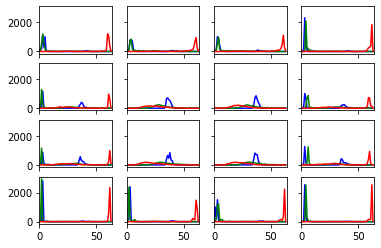

In [121]:
plt.figure()
img_n = 0
histr = all_hist[dict_class[0],img_n] # hist of first image in class 0 
print(histr.shape)

fig, axes = plt.subplots(grid,grid,sharex=True, sharey=True)
color = ('b','g','r')
for i in range(grid):
    for j in range(grid):
        #print(i*grid+j)
        for c, col in enumerate(color):

            axes[i,j].plot(histr[c][i*grid+j], color = col)
            axes[i,j].set_xlim([0, bin_num])
        

        
plt.savefig("class0_img{}_color_hist_bin{}_gridsize{}.jpg".format(img_n,bin_num,grid),dpi=150)

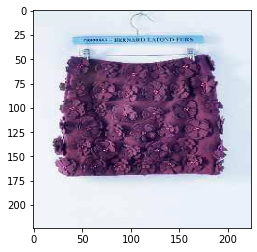

In [122]:
plt.imshow(imgs[0][img_n])
plt.savefig("class0_img[0]")

# Co-occurence Matrix 

In [146]:
def gray_level(pattern,pixel_range=16):
    return np.floor(pattern/pixel_range)

def co_occurence(input_pattern,pixel_range=16):
    co_m_01 = np.zeros((pixel_range,pixel_range))
    co_m_10 = np.zeros((pixel_range,pixel_range))
    co_m_11 = np.zeros((pixel_range,pixel_range))
    input_pattern = np.int_(gray_level(input_pattern,pixel_range))
    # d = (0,1)
    leng = input_pattern.shape[0]
    for i in range(leng):
        for j in range(leng-1):
            co_m_01[input_pattern[i,j],input_pattern[i,j+1]] +=1
    # d = (1,0)
    for i in range(leng):
        for j in range(leng-1):
            co_m_10[input_pattern[j,i],input_pattern[j+1,i]] +=1
    for i in range(leng-1):
        for j in range(leng-1):
            co_m_11[input_pattern[i,j],input_pattern[i+1,j+1]] +=1
    return np.array([co_m_01, co_m_10, co_m_11])
#co_occurence(np.array([[16,25],[26,244]]))

In [148]:
all_occu = {}
bin_num = 64
grid = 4
image_size = 224
for c , class_imgs in enumerate(imgs):
    for n, img in enumerate(class_imgs):
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_hist = []
        
        grid_h = int(image_size/grid)
        grid_w = int(image_size/grid)
        hist_arr = []
        for i in range(grid):
            for j in range(grid):
                gray_hist += [co_occurence(img[i*grid_h:i*grid_h+grid_h,j*grid_w:j*grid_w+grid_w])]

        all_occu[dict_class[c],n] = np.array(np.array(gray_hist))
all_occu[dict_class[0],0].shape

(64, 3, 16, 16)

In [149]:
#write_csv(method="Co_ocurence")

# Edge Histogram Descriptor

In [188]:
verti = np.array([[1,-1],[1,-1]])
hori = np.array([[1,1],[-1,-1]])
deg45 = np.array([[2**0.5,0],[0,-(2**0.5)]])
deg135 = np.array([[0,2**0.5],[-(2**0.5),0]])
non_dir = np.array([[2,-2],[-2,2]])


def EHD(input_pattern,block_size = 4,T_edge=0):
    # 56*56 pattern
    # 0 : "vertical", 1 : horizontal , 2 : 45 degree, 3: 135 degree , 4 : non-direction 
    
    #split into 14*14 image block when block size = 4
    
    l = input_pattern.shape[0]
    # split each block into 4 sub block
    block_size /= 2
    block_size = int(block_size)
    block_l = int(l / block_size)
    new_pattern = np.zeros((block_l, block_l))
    for i in range(block_l):
        for j in range(block_l):
             
            new_pattern[i][j] = np.average(input_pattern[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size])
    
    hist = [0,0,0,0,0]
    block_l /=2
    block_l = int(block_l)
    verti_p = np.zeros((block_l, block_l))
    hori_p =np.zeros((block_l, block_l))
    deg45_p =np.zeros((block_l, block_l))
    deg135_p =np.zeros((block_l, block_l))
    non_dir_p = np.zeros((block_l, block_l))
    for i in range(0,block_l):
        for j in range(0,block_l):
            verti_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],verti))
            hori_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],hori))
            deg45_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],deg45))
            deg135_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],deg135))
            non_dir_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],non_dir))
            
    """verti_p = cv2.filter2D(input_pattern,dst=-1,ddepth=-1, kernel=verti)
    hori_p = cv2.filter2D(input_pattern,dst=-1,ddepth=-1, kernel=hori)
    deg45_p = cv2.filter2D(input_pattern,dst=-1,ddepth=-1, kernel=deg45)
    deg135_p = cv2.filter2D(input_pattern,dst=-1,ddepth=-1, kernel=deg135)
    non_dir_p = cv2.filter2D(input_pattern,dst=-1,ddepth=-1, kernel=non_dir)"""
    leng = verti_p.shape[0]
    for i in range(leng):
        for j in range(leng):
            cmp_a = np.array([verti_p[i,j],hori_p[i,j],deg45_p[i,j],deg135_p[i,j],non_dir_p[i,j]])
            index = np.argmax( cmp_a )
            if cmp_a[index] > T_edge:
                hist[index]+=1
    return hist

In [213]:
all_edge = {}
#bin_num = 64
grid = 8
image_size = 224
for c , class_imgs in enumerate(imgs):
    for n, img in enumerate(class_imgs):
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_hist = []
        
        grid_h = int(image_size/grid)
        grid_w = int(image_size/grid)
        hist_arr = []
        for i in range(grid):
            for j in range(grid):
                gray_hist += [EHD(img[i*grid_h:i*grid_h+grid_h,j*grid_w:j*grid_w+grid_w],T_edge=40)]

        all_edge[dict_class[c],n] = np.array(np.array(gray_hist))
all_edge[dict_class[0],0].shape

(64, 5)

# EHD Score, Ranking, Get AP 

In [214]:
top = 19
AP = {}
for c, hist in all_edge.items():
    target = c[0]
    score ={}
    
    for c_t, hist_t in all_edge.items():
        
        if c == c_t :
            continue
        score[c_t] = similarity(hist, hist_t,dim=2)
    #ranking
    scores = sorted(score.items(), key=lambda kv: kv[1])
    #print(score)
    #get top19
    rank = 0
    #print(target)
    correct = 0.0
    for t,score in scores:
        #print(t[0])
        if t[0] == target:
            correct += 1.0
        rank += 1
        if rank == top:
            break
    AP[c] = correct/top

In [215]:
class_map_arr , all_map = m_ap(AP,top)
compare_map = sorted(class_map_arr.items(), key=lambda kv: kv[1])
print("Worst 2 Categories")
print(compare_map[0],compare_map[1])
print("Best 2 Categories")
print(compare_map[-1],compare_map[-2])

print(all_map)

Worst 2 Categories
('hand_cream', 0.049861495844875335) ('bracelet', 0.0637119113573407)
Best 2 Categories
('goggles', 0.445983379501385) ('gge_snack', 0.335180055401662)
0.14666666666666664


In [216]:
#threshold = 0
write_csv(method="EHD",bin_num=5, grid=grid)

(64, 5)
[0 0 0 0 0]
[0 1 0 0 0]
[0 7 0 0 0]
[1 6 1 0 1]
[0 7 0 0 0]
[0 7 0 0 0]
[0 2 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[2 3 2 1 2]
[1 9 2 1 0]
[ 0 17  3  0  1]
[ 3 11  4  0  0]
[2 6 2 2 3]
[2 3 0 3 3]
[0 0 0 0 0]
[0 0 1 0 0]
[6 1 4 3 3]
[4 0 0 5 9]
[2 0 3 1 5]
[ 2  1  1  1 12]
[4 2 1 4 3]
[0 0 2 8 8]
[0 0 0 0 0]
[0 0 0 0 0]
[6 2 4 1 8]
[3 1 1 5 4]
[3 5 0 1 5]
[3 1 2 1 7]
[1 1 2 2 9]
[1 0 0 8 4]
[0 0 0 0 0]
[4 1 0 0 1]
[4 5 1 2 3]
[4 4 1 7 5]
[8 3 0 1 8]
[4 1 2 5 6]
[3 1 1 2 6]
[1 0 3 9 6]
[0 0 0 0 0]
[5 1 0 0 3]
[ 7  0  1  3 12]
[3 2 2 0 7]
[4 1 1 1 7]
[3 3 1 3 9]
[3 1 1 4 8]
[4 1 0 6 9]
[0 0 0 1 1]
[0 0 0 0 0]
[1 0 0 0 1]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]


<Figure size 432x288 with 0 Axes>

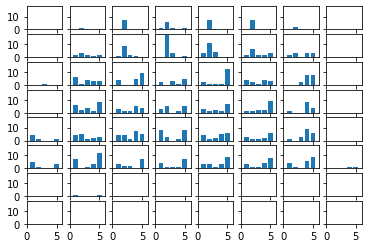

In [217]:
plt.figure()
img_n = 0
histr = all_edge[dict_class[0],img_n] # hist of first image in class 0 
print(histr.shape)
threshold = 40
fig, axes = plt.subplots(grid,grid,sharex=True, sharey=True)
color = ('b','g','r')
for i in range(grid):
    for j in range(grid):
        #print(i*grid+j)
        print(histr[i*grid+j])
        axes[i,j].bar([1,2,3,4,5],histr[i*grid+j])
        axes[i,j].set_xlim([0, 6])
        

        
plt.savefig("class0_img{}_EHD_gridsize{}_threshold{}.jpg".format(img_n,grid,threshold),dpi=150)

# Local Feature